# 시간대별 지하철 및 버스 혼잡도 분석
## 1. 데이터 개요
이 분석에서는 버스와 지하철의 시간대별 혼잡도를 비교하고, 평균 등하교 시간대에 초점을 맞추어 최적의 경로를 파악하고자 합니다. 이를 위해 다음과 같은 데이터를 사용하였습니다

버스 승하차 인원 정보: 버스 정류소에서 시간대별 승차 및 하차 인원 수<br>
버스 정류소 위치 정보: 각 버스 정류소의 위치 정보<br>
지하철 역별 시간대 혼잡도: 지하철 역에서 시간대별 혼잡도<br>
지하철 승하차 인원 정보: 지하철 역에서 시간대별 승차 및 하차 인원 수

In [14]:
import site
site.getsitepackages()

['/Users/hyun/anaconda3/lib/python3.11/site-packages']

In [15]:
import sys
import pandas as pd
import numpy as np
import seaborn as sns

print(sys.version)
print(pd.__version__)
print(np.__version__)
print(sns.__version__)

3.11.9 | packaged by conda-forge | (main, Apr 19 2024, 18:34:54) [Clang 16.0.6 ]
2.1.4
1.24.3
0.12.2


In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import re

# 한글 글꼴 설정
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

# 파일 불러오기
bus_boarding_info = pd.read_csv('버스승하차인원정보.csv', low_memory=False)
bus_stop_location = pd.read_csv('버스정류소위치정보.csv', encoding='utf-8')
subway_congestion = pd.read_csv("역별시간대혼잡도.csv", encoding='utf-8')
subway_boarding_info = pd.read_csv("지하철승하차인원정보.csv", encoding='utf-8')

# 동양미래대학교 위치 (위도와 경도)
school_location = {'latitude': 37.498, 'longitude': 127.027}


### 데이터 확인해보기

In [18]:
bus_boarding_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41810 entries, 0 to 41809
Data columns (total 57 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   사용년월        41810 non-null  int64 
 1   노선번호        41810 non-null  object
 2   노선명         41810 non-null  object
 3   표준버스정류장ID   41810 non-null  int64 
 4   버스정류장ARS번호  41810 non-null  object
 5   역명          41810 non-null  object
 6   00시승차총승객수   41810 non-null  int64 
 7   00시하차총승객수   41810 non-null  int64 
 8   1시승차총승객수    41810 non-null  int64 
 9   1시하차총승객수    41810 non-null  int64 
 10  2시승차총승객수    41810 non-null  int64 
 11  2시하차총승객수    41810 non-null  int64 
 12  3시승차총승객수    41810 non-null  int64 
 13  3시하차총승객수    41810 non-null  int64 
 14  4시승차총승객수    41810 non-null  int64 
 15  4시하차총승객수    41810 non-null  int64 
 16  5시승차총승객수    41810 non-null  int64 
 17  5시하차총승객수    41810 non-null  int64 
 18  6시승차총승객수    41810 non-null  int64 
 19  6시하차총승객수    41810 non-null  int64 
 20  7시승차총승

In [19]:
bus_stop_location.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50465 entries, 0 to 50464
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   STDR_DE     50465 non-null  int64  
 1   NODE_ID     50465 non-null  int64  
 2   STTN_NO     50465 non-null  int64  
 3   STTN_NM     50465 non-null  object 
 4   CRDNT_X     50465 non-null  object 
 5   CRDNT_Y     50465 non-null  float64
 6   STTN_TY     50465 non-null  float64
 7   Unnamed: 7  8 non-null      float64
dtypes: float64(3), int64(3), object(2)
memory usage: 3.1+ MB


In [20]:
subway_congestion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1641 entries, 0 to 1640
Data columns (total 45 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   연번      1641 non-null   int64  
 1   요일구분    1641 non-null   object 
 2   호선      1641 non-null   int64  
 3   역번호     1641 non-null   int64  
 4   출발역     1641 non-null   object 
 5   상하구분    1641 non-null   object 
 6   5시30분   1641 non-null   float64
 7   6시00분   1641 non-null   float64
 8   6시30분   1641 non-null   float64
 9   7시00분   1641 non-null   float64
 10  7시30분   1641 non-null   float64
 11  8시00분   1641 non-null   float64
 12  8시30분   1641 non-null   float64
 13  9시00분   1641 non-null   float64
 14  9시30분   1641 non-null   float64
 15  10시00분  1641 non-null   float64
 16  10시30분  1641 non-null   float64
 17  11시00분  1641 non-null   float64
 18  11시30분  1641 non-null   float64
 19  12시00분  1641 non-null   float64
 20  12시30분  1641 non-null   float64
 21  13시00분  1641 non-null   float64
 22  

In [21]:
subway_boarding_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66207 entries, 0 to 66206
Data columns (total 52 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   사용월           66207 non-null  int64 
 1   호선명           66207 non-null  object
 2   지하철역          66207 non-null  object
 3   04시-05시 승차인원  66207 non-null  int64 
 4   04시-05시 하차인원  66207 non-null  int64 
 5   05시-06시 승차인원  66207 non-null  int64 
 6   05시-06시 하차인원  66207 non-null  int64 
 7   06시-07시 승차인원  66207 non-null  int64 
 8   06시-07시 하차인원  66207 non-null  int64 
 9   07시-08시 승차인원  66207 non-null  int64 
 10  07시-08시 하차인원  66207 non-null  int64 
 11  08시-09시 승차인원  66207 non-null  int64 
 12  08시-09시 하차인원  66207 non-null  int64 
 13  09시-10시 승차인원  66207 non-null  int64 
 14  09시-10시 하차인원  66207 non-null  int64 
 15  10시-11시 승차인원  66207 non-null  int64 
 16  10시-11시 하차인원  66207 non-null  int64 
 17  11시-12시 승차인원  66207 non-null  int64 
 18  11시-12시 하차인원  66207 non-null  int64 
 19  12시-

In [22]:
subway_boarding_info.head()

,사용월,호선명,지하철역,04시-05시 승차인원,04시-05시 하차인원,05시-06시 승차인원,05시-06시 하차인원,06시-07시 승차인원,06시-07시 하차인원,07시-08시 승차인원,...,23시-24시 하차인원,00시-01시 승차인원,00시-01시 하차인원,01시-02시 승차인원,01시-02시 하차인원,02시-03시 승차인원,02시-03시 하차인원,03시-04시 승차인원,03시-04시 하차인원,작업일자
0,202404,1호선,동대문,708,7,11309,2206,9917,7632,16477,...,9476,693,3153,0,266,0,0,0,0,20240503
1,202404,1호선,동묘앞,231,1,3091,802,4051,5422,9024,...,4900,151,2459,2,322,0,0,0,0,20240503
2,202404,1호선,서울역,658,24,8560,9158,14541,62765,43682,...,14443,3203,3771,3,263,0,0,0,0,20240503
3,202404,1호선,시청,94,2,2321,5550,4123,26788,7965,...,4110,661,1172,3,40,1,0,0,0,20240503
4,202404,1호선,신설동,371,25,8785,2166,10319,9477,22808,...,9376,423,3048,0,0,0,0,0,0,20240503


## 2.혼잡도 계산
혼잡도는 각 시간대별 승차 인원과 하차 인원의 차이를 통해 계산되었습니다. 승차 인원이 많고 하차 인원이 적을수록 혼잡도가 높아지며, 반대의 경우 혼잡도가 낮아집니다.

In [46]:
# 시간대 추출 (열 이름에서 숫자 부분만 추출)
subway_boarding_columns = subway_boarding_info.filter(like='승차').columns.tolist()
subway_alighting_columns = subway_boarding_info.filter(like='하차').columns.tolist()
time_columns = [int(re.findall(r'\d+', col)[0]) for col in subway_boarding_columns]

# 지하철 혼잡도 계산
subway_congestion_by_time = pd.DataFrame({
    '시간대': time_columns,
    '혼잡도': [
        subway_boarding_info[col].mean() - subway_boarding_info[subway_alighting_columns[i]].mean()
        if col in subway_boarding_info.columns and subway_alighting_columns[i] in subway_boarding_info.columns
        else 0
        for i, col in enumerate(subway_boarding_columns)
    ]
})

# 버스 혼잡도 계산
bus_boarding_columns = bus_boarding_info.filter(like='승차').columns.tolist()
bus_alighting_columns = bus_boarding_info.filter(like='하차').columns.tolist()
time_columns_bus = [int(re.findall(r'\d+', col)[0]) for col in bus_boarding_columns]

bus_congestion_by_time = pd.DataFrame({
    '시간대': time_columns_bus,
    '혼잡도': [
        bus_boarding_info[col].mean() - bus_boarding_info[bus_alighting_columns[i]].mean()
        if col in bus_boarding_info.columns and bus_alighting_columns[i] in bus_boarding_info.columns
        else 0
        for i, col in enumerate(bus_boarding_columns)
    ]
})


## 3. 최적 경로 분석 함수 정의


In [50]:
# 최적 경로 분석 함수
def find_optimal_route(congestion_data, travel_times):
    optimal_routes = []
    for index, row in congestion_data.iterrows():
        time = int(row['시간대'])  # 시간을 정수로 변환
        optimal_route = {
            '시간대': time,
            '최적 경로': None,
            '최소 혼잡도': float('inf'),
        }
        for route, time_info in travel_times.items():
            if time < len(time_info['혼잡도']) and abs(time_info['혼잡도'][time]) < abs(optimal_route['최소 혼잡도']):
                optimal_route['최적 경로'] = route
                optimal_route['최소 혼잡도'] = time_info['혼잡도'][time]
        optimal_routes.append(optimal_route)
    return pd.DataFrame(optimal_routes)


# 두 데이터를 결합하여 travel_times 데이터 생성
travel_times = {
    '지하철 경로': {'혼잡도': subway_congestion_by_time['혼잡도'].tolist()},
    '버스 경로': {'혼잡도': bus_congestion_by_time['혼잡도'].tolist()},
}

# 최적 경로 찾기
optimal_routes_df = find_optimal_route(subway_congestion_by_time, travel_times)

# 최적 경로 출력
print(optimal_routes_df)


    시간대   최적 경로     최소 혼잡도
0     4   버스 경로   8.475030
1     5   버스 경로   3.710476
2     6   버스 경로  14.824276
3     7  지하철 경로   9.974761
4     8   버스 경로  -9.571203
5     9   버스 경로  -5.870916
6    10   버스 경로  -0.351830
7    11   버스 경로   3.762593
8    12   버스 경로   6.641210
9    13   버스 경로   3.669409
10   14   버스 경로   6.767472
11   15   버스 경로   9.310213
12   16   버스 경로  11.167281
13   17   버스 경로  11.147118
14   18   버스 경로   3.001818
15   19   버스 경로 -13.556541
16   20   버스 경로  -1.127051
17   21   버스 경로   1.987730
18   22  지하철 경로  -0.849200
19   23  지하철 경로  -0.064283
20    0   버스 경로  -5.701626
21    1   버스 경로  -1.525425
22    2   버스 경로  -0.263191
23    3   버스 경로   0.071036


## 4. 평균 등하교 시간대의 최적 경로 시각화

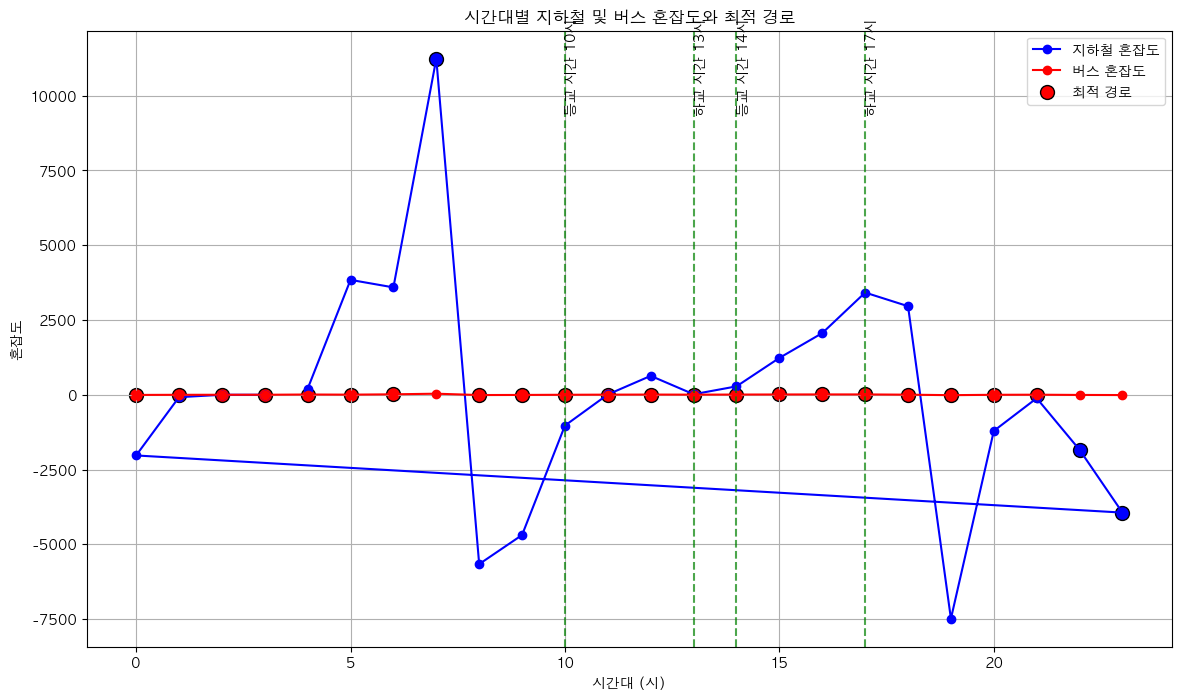

In [51]:
# 시각화 함수 정의
def plot_congestion_and_routes(subway_data, bus_data, optimal_routes):
    plt.figure(figsize=(14, 8))
    
    # 지하철 혼잡도 시각화
    plt.plot(subway_data['시간대'], subway_data['혼잡도'], label='지하철 혼잡도', color='blue', marker='o')
    
    # 버스 혼잡도 시각화
    plt.plot(bus_data['시간대'], bus_data['혼잡도'], label='버스 혼잡도', color='red', marker='o')
    
    # 최적 경로 표시
    for index, row in optimal_routes.iterrows():
        time = row['시간대']
        if row['최적 경로'] == '지하철 경로':
            plt.scatter(time, subway_data[subway_data['시간대'] == time]['혼잡도'].values[0], color='blue', s=100, edgecolors='black', label='최적 경로' if index == 0 else "")
        else:
            plt.scatter(time, bus_data[bus_data['시간대'] == time]['혼잡도'].values[0], color='red', s=100, edgecolors='black', label='최적 경로' if index == 0 else "")
    
    # 평균 등하교 시간대 강조
    avg_times = {'등교 시간': [10, 14], '하교 시간': [13, 17]}
    for key, times in avg_times.items():
        for time in times:
            plt.axvline(x=time, linestyle='--', color='green', alpha=0.7)
            plt.text(time, plt.ylim()[1]*0.9, f'{key} {time}시', rotation=90, verticalalignment='center')
    
    plt.title('시간대별 지하철 및 버스 혼잡도와 최적 경로')
    plt.xlabel('시간대 (시)')
    plt.ylabel('혼잡도')
    plt.legend()
    plt.grid(True)
    plt.show()

# 혼잡도 및 최적 경로 시각화 함수 호출
plot_congestion_and_routes(subway_congestion_by_time, bus_congestion_by_time, optimal_routes_df)

지하철 혼잡도: 지하철은 평균 등교 시간대인 오전 10시와 오후 2시에 혼잡도가 상대적으로 높음. 특히 오전 10시에는 혼잡도가 크게 증가하는 것을 볼 수 있다.<br><br>
버스 혼잡도: 버스의 경우, 혼잡도는 상대적으로 낮았으며, 특정 시간대에 큰 변동이 없는 편. <br><br>
평균 등하교 시간대: 등교 시간대인 오전 10시와 오후 2시, 하교 시간대인 오후 1시와 오후 5시에는 혼잡도가 더 높은 경향이 있으며, 이는 학생들이 주로 이 시간대에 이동하기 때문으로 보임.

## 5.결론
### 시간대별 최적 경로
* 오전 10시 및 오후 2시 등교 시간 : 버스 경로가 최적 경로로 선정되었습니다. 이 시간대에는 버스의 혼잡도가 상대적으로 낮아 지하철보다 더 나은 선택입니다.
* 오후 1시 하교 시간 : 버스 경로가 최적 경로로 선정되었습니다. 지하철 경로도 혼잡도가 낮지만, 버스 경로가 더 나은 선택으로 분석되었습니다.
* 오후 5시 하교 시간 : 버스 경로가 최적 경로로 선정되었습니다. 이 시간대에는 퇴근 시간과 겹쳐 지하철의 혼잡도가 매우 높아 버스 경로가 더 나은 선택입니다.
### 결론 및 권장사항
* 버스 경로 추천 : 대부분의 시간대에서 버스 경로가 최적 경로로 선정되었습니다. 이는 버스의 혼잡도가 지하철보다 상대적으로 낮기 때문입니다.
* 지하철 경로 : 특정 시간대 (예: 오전 7시, 오후 3시)에는 지하철 경로가 최적 경로로 선정될 수 있습니다. 이 시간대에는 지하철 혼잡도가 낮아 상대적으로 더 나은 선택이 될 수 있습니다.
* 유동적인 경로 선택 : 학생들은 실시간 교통 상황을 고려하여 유동적으로 경로를 선택하는 것이 좋습니다. 특히, 특정 이벤트나 날씨에 따라 혼잡도가 변동될 수 있으므로 주기적인 확인이 필요합니다.
